In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import sys
import os
# os.chdir("/Users/zyxu/Documents/R/23spring")
os.chdir("D:\OneDrive\OneDrive - UW-Madison\Kris\Code\curatedMetagenomicDataAnalyses\\notebook")
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import jax.numpy as jnp

# Load the matrix from the CSV file
matrix_data = pd.read_csv("./dataset/sim_matrix_data.csv")

matrix_data.shape

study_names = pd.read_csv("./dataset/sim_study_name.csv")
study_names['study'] = study_names['x']
study_names

,x,study
0,A,A
1,A,A
2,A,A
3,A,A
4,A,A
...,...,...
995,E,E
996,E,E
997,E,E
998,E,E


In [3]:
rank = 20

In [4]:
threshold = 0.98 * matrix_data.shape[0]
cols_with_zeros = (matrix_data == 0).sum(axis=0) > threshold
selected_species = matrix_data.columns[cols_with_zeros]
threshold_study = 1

results = {}

for species in selected_species:
    species_data = matrix_data[species]
    
    zero_data = study_names.copy()
    zero_data['zeros'] = (species_data == 0)
    
    # Count total and zero samples for each study
    total_samples_per_study = zero_data.groupby('study').size()
    zero_samples_per_study = zero_data.groupby('study').sum(numeric_only=True)['zeros']
    
    # Find studies with a high proportion of zeros
    high_zero_studies = (zero_samples_per_study / total_samples_per_study) >= threshold_study
    # print((zero_samples_per_study / total_samples_per_study))
    
    results[species] = high_zero_studies[high_zero_studies].index.tolist()

unique_studies = study_names['study'].unique()


In [6]:
V = torch.load("output/sim/best_V.pt")
V.shape

torch.Size([200, 10])

In [7]:
studies_data = [matrix_data[study_names['study'] == study].values for study in unique_studies]
# Create C matrices for each study based on species with a high proportion of zeros
def construct_C_for_study(study, results, matrix_data):
    C = jnp.eye(matrix_data.shape[1])
    species_with_high_zeros = results.keys() & set(matrix_data.columns)
    for species in species_with_high_zeros:
        if study in results[species]:
            species_index = matrix_data.columns.get_loc(species)
            C = C.at[species_index, species_index].set(0)
    return C

# Constructing Cs for each study
Cs = [construct_C_for_study(study, results, matrix_data) for study in unique_studies]


In [8]:

study_decompositions = {}
for i, study in enumerate(unique_studies):
    X = studies_data[i]
    print(np.dot(X, Cs[i]).shape)
    U, Sigma, _ = np.linalg.svd(np.dot(X, Cs[i]) @ V.detach().numpy(), full_matrices=False)
    U, Sigma = U[:, :rank], Sigma[:rank]
    study_decompositions[study] = (U, Sigma)

(100, 200)
(150, 200)
(200, 200)
(250, 200)
(300, 200)


In [9]:
study_decompositions["A"][0].shape

(100, 10)

# traditional

In [10]:

import numpy as np
import pandas as pd

# Assuming matrix_data is a DataFrame and study_names is a column vector of the same length

unique_studies = study_names['x'].unique()
study_decompositions_traditional = {}

for study in unique_studies:
    # Step 1: Select rows for the current study
    X = matrix_data[study_names['x'] == study].values
    
    # Step 2: SVD decomposition
    U, Sigma, Vt = np.linalg.svd(X, full_matrices=False)
    
    # Step 3: Retain only top 1/10 singular values and vectors
    U = U[:, :rank]
    Sigma = Sigma[:rank]
    Vt = Vt[:rank, :]
    
    # Step 4: Construct C matrix
    C = np.eye(matrix_data.shape[1])
    species_with_high_zeros = results.keys() & set(matrix_data.columns)
    for species in species_with_high_zeros:
        if study in results[species]:
            species_index = matrix_data.columns.get_loc(species)
            C[species_index, species_index] = 0
    
    study_decompositions_traditional[study] = (U, Sigma, Vt, C)


In [11]:
study_decompositions_traditional["A"][0].shape

(100, 20)

## ground truth

In [13]:
import json
# Load the JSON file
with open('./dataset/sim_study_groundTruth.json', 'r') as json_file:
    sim_study_groundTruth = json.load(json_file)

In [14]:
np.array(sim_study_groundTruth['A']).shape

(100, 20)

## visz

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample study
study = unique_studies[0]

def plot_study_U(study):
    U_study = study_decompositions[study][0]
    U_study_traditional = study_decompositions_traditional[study][0]
    # U_difference = U_study - U_study_traditional
    U_groundTruth = np.array(sim_study_groundTruth[study])

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Heatmap of U from study_decompositions
    sns.heatmap(U_study, ax=axes[0], cmap='coolwarm', cbar=False)
    axes[0].set_title('U from study_decompositions')

    # Heatmap of U from study_decompositions_traditional
    sns.heatmap(U_study_traditional, ax=axes[1], cmap='coolwarm', cbar=False)
    axes[1].set_title('U from study_decompositions_traditional')

    # Ground truth U
    sns.heatmap(U_groundTruth, ax=axes[2], cmap='coolwarm')
    axes[2].set_title('Ground truth U matrices')

    # Heatmap of the difference
    # sns.heatmap(U_difference, ax=axes[2], cmap='coolwarm')
    # axes[2].set_title('Difference between U matrices')



    plt.tight_layout(pad=1.0)
    plt.show()

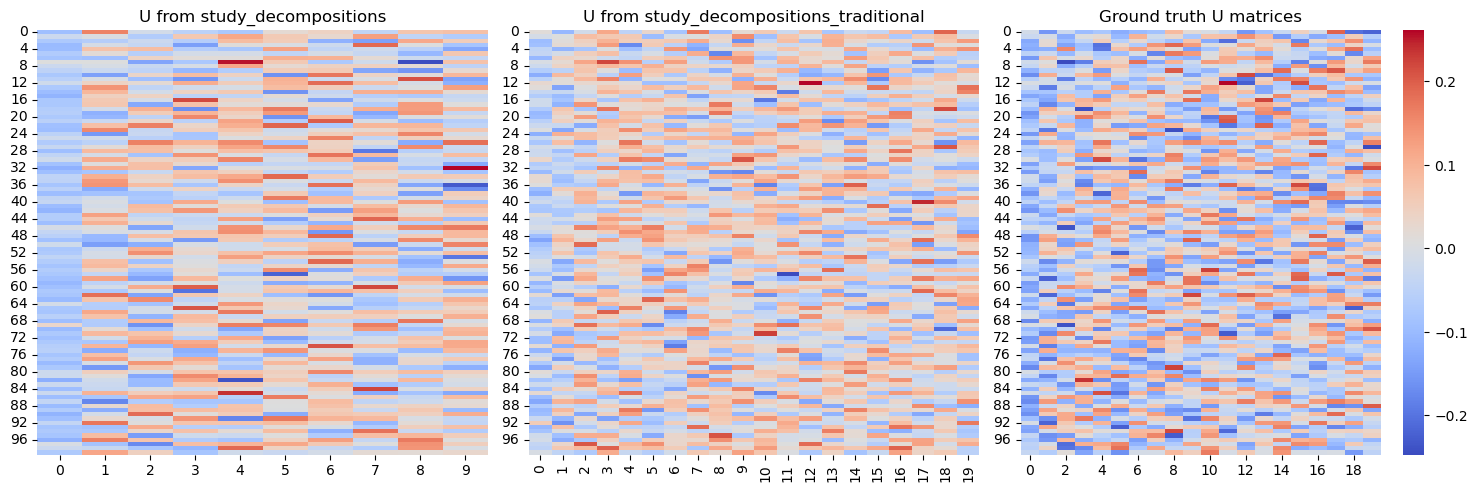

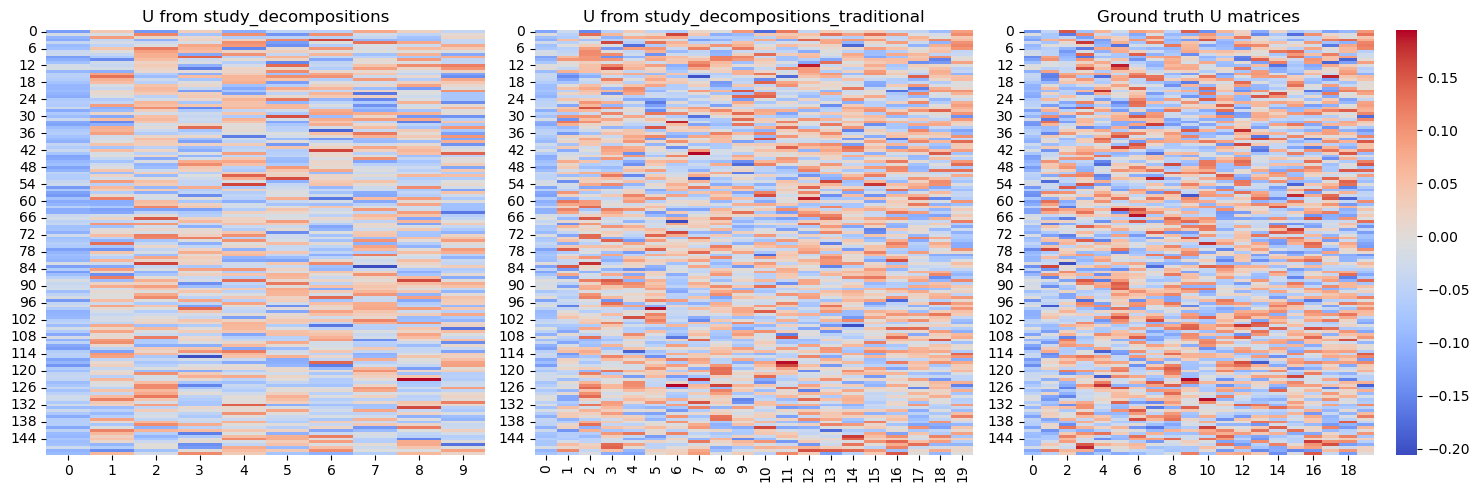

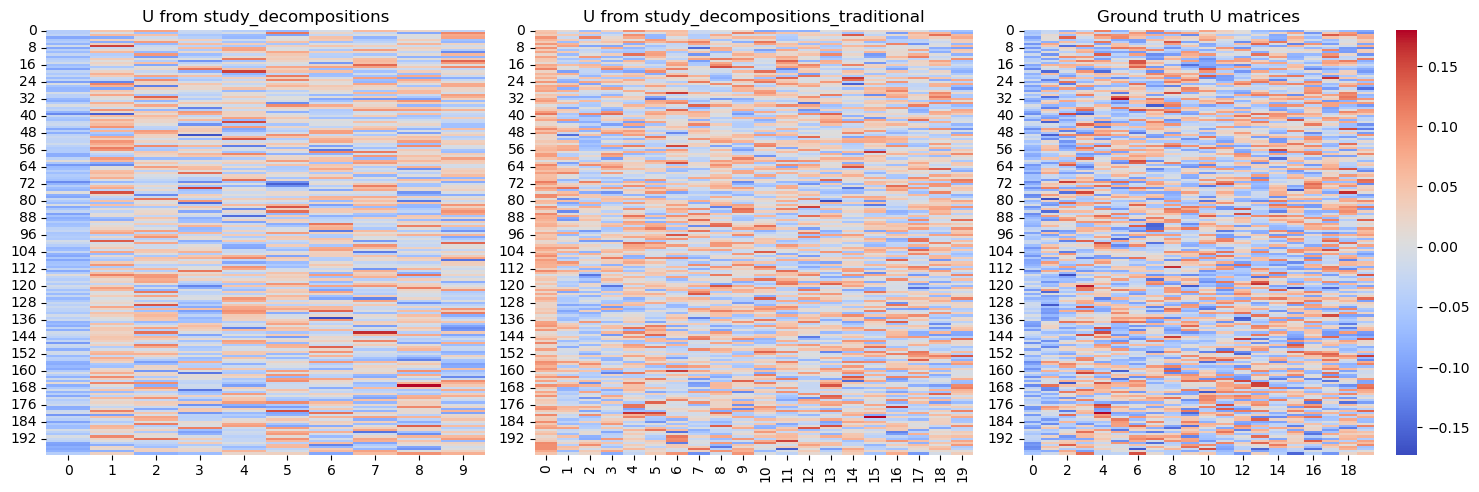

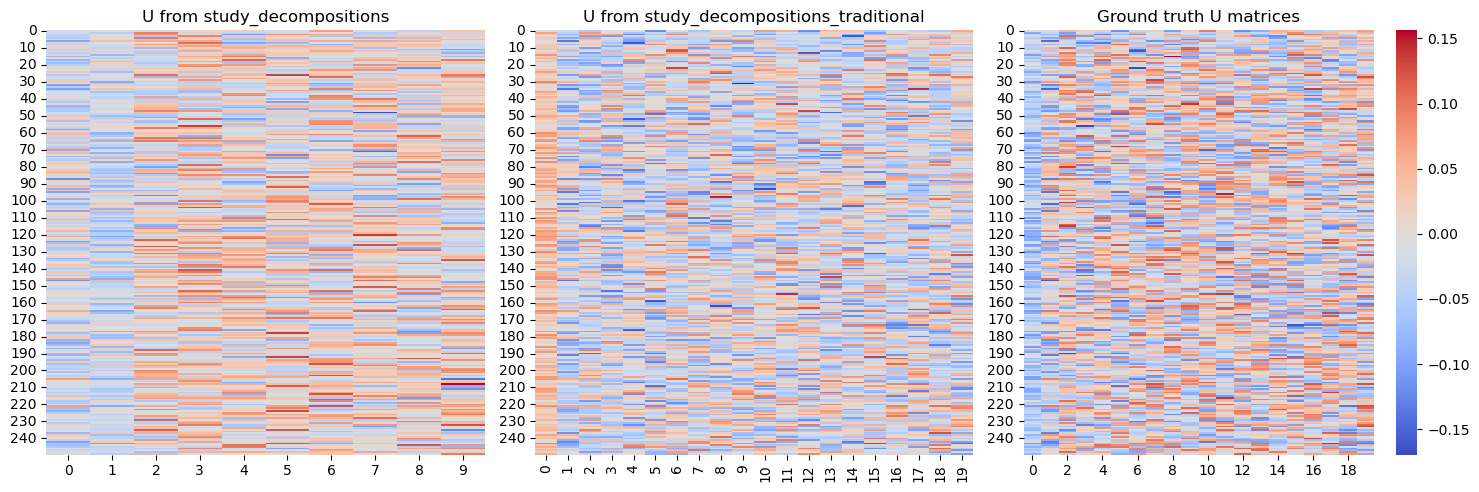

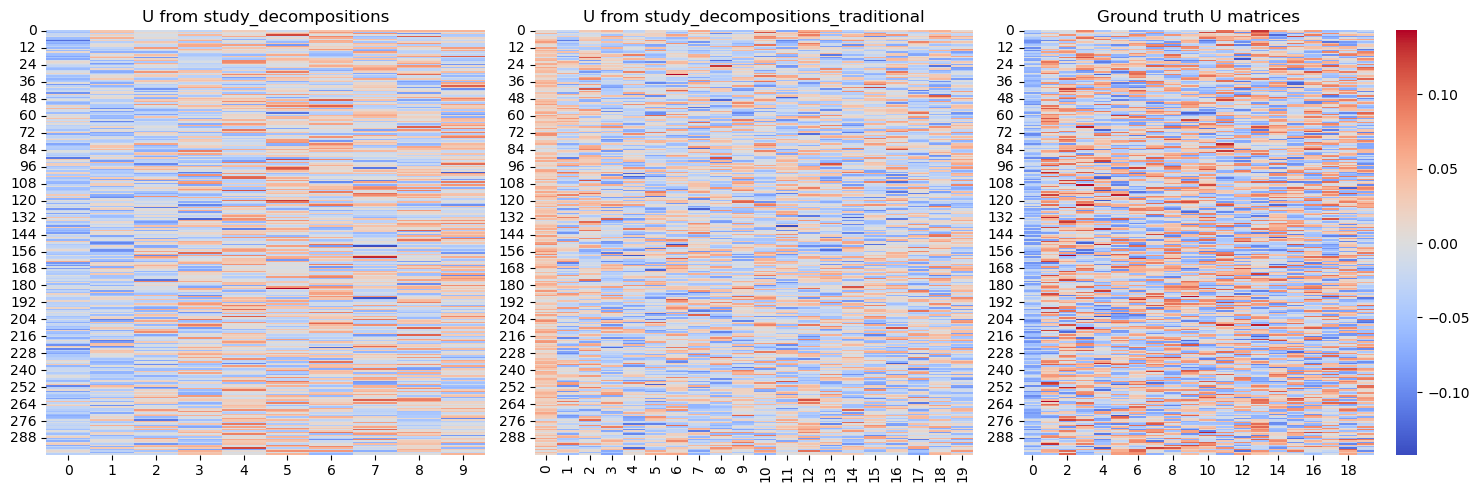

In [16]:
for study in unique_studies:
    plot_study_U(study)

In [17]:
from collections import defaultdict 

def com_loss(study):
    U_study = study_decompositions[study][0]
    U_study_traditional = study_decompositions_traditional[study][0]
    # U_difference = U_study - U_study_traditional
    U_groundTruth = np.array(sim_study_groundTruth[study])
    # Compute difference matrices
    diff_U_study = U_study - U_groundTruth
    diff_U_study_traditional = U_study_traditional - U_groundTruth

    # Compute Frobenius norms
    norm_U_study = np.linalg.norm(diff_U_study, 'fro')
    norm_U_study_traditional = np.linalg.norm(diff_U_study_traditional, 'fro')

    print(f"Frobenius norm of the difference between U_study and U_groundTruth: {norm_U_study}")
    print(f"Frobenius norm of the difference between U_study_traditional and U_groundTruth: {norm_U_study_traditional}")

    return norm_U_study, norm_U_study_traditional
loss = defaultdict(list)

for study in unique_studies:
    loss["study"].append(study)
    norm_U_study, norm_U_study_traditional = com_loss(study)
    loss["ours"].append(norm_U_study)
    loss["SVD"].append(norm_U_study_traditional)

ValueError: operands could not be broadcast together with shapes (100,10) (100,20) 

In [18]:
import pandas as pd
pd.DataFrame(loss)

,study,ours,SVD
0,A,6.107140,6.158457
1,B,6.117442,5.311662
2,C,6.156957,6.675255
3,D,6.600473,5.728456
4,E,6.265716,5.980590
